In [17]:
!pip install ultralytics opencv-python-headless torchvision matplotlib --quiet

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from ultralytics import YOLO
import matplotlib.pyplot as plt
from torchvision import models, transforms
import os


In [18]:
model_path = "best.pt"

if not os.path.exists(model_path):
    raise FileNotFoundError("❌ best.pt not found. Make sure it's in the same directory!")

model = YOLO(model_path)

In [19]:
def detect_players(video_path, max_frames=50):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Error: Cannot open video {video_path}")
        return []

    detections = []
    frame_idx = 0

    while cap.isOpened() and frame_idx < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        player_boxes = [tuple(map(int, box[:4])) for box in boxes]
        detections.append((frame, player_boxes))
        frame_idx += 1

    cap.release()

    if len(detections) == 0:
        print(f"⚠️ No players detected in {video_path}")

    return detections


In [20]:
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def get_embedding(crop):
    try:
        tensor = transform(crop).unsqueeze(0)
        with torch.no_grad():
            return resnet(tensor).squeeze(0)
    except Exception as e:
        print("⚠️ Error extracting embedding:", e)
        return torch.zeros(512)

In [21]:
def match_players(broadcast_detections, tacticam_detections):
    # First extract all embeddings from broadcast
    broadcast_embeds = []
    for frame, boxes in broadcast_detections:
        for box in boxes:
            x1, y1, x2, y2 = box
            crop = frame[y1:y2, x1:x2]
            emb = get_embedding(crop)
            broadcast_embeds.append(emb)

    matched_ids = []
    for frame, boxes in tacticam_detections:
        for box in boxes:
            x1, y1, x2, y2 = box
            crop = frame[y1:y2, x1:x2]
            emb = get_embedding(crop)

            best_sim, best_idx = -1, -1
            for i, ref_emb in enumerate(broadcast_embeds):
                sim = F.cosine_similarity(emb.unsqueeze(0), ref_emb.unsqueeze(0)).item()
                if sim > best_sim:
                    best_sim, best_idx = sim, i
            matched_ids.append((box, best_idx))
    return matched_ids

In [29]:
def show_matches(frame, matched_ids):
    print(f"🧪 Total matched boxes: {len(matched_ids)}")
    
    if not matched_ids:
        print("⚠️ No matched players to show.")
        return

    for box, pid in matched_ids:
        print(f"Drawing box {box} with ID {pid}")
        x1, y1, x2, y2 = box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, f"ID: {pid}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Tacticam Matches with Broadcast IDs")
    plt.axis("off")
    plt.tight_layout()
    plt.show()



0: 384x640 3 players, 913.5ms
Speed: 67.0ms preprocess, 913.5ms inference, 34.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 750.0ms
Speed: 3.8ms preprocess, 750.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 742.7ms
Speed: 3.2ms preprocess, 742.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 746.4ms
Speed: 2.9ms preprocess, 746.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 751.2ms
Speed: 2.9ms preprocess, 751.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 1 referee, 739.4ms
Speed: 3.3ms preprocess, 739.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 12 players, 1 referee, 727.2ms
Speed: 2.8ms preprocess, 727.2ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 14 players, 1 referee, 


0: 384x640 22 players, 715.9ms
Speed: 2.6ms preprocess, 715.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 players, 741.0ms
Speed: 2.4ms preprocess, 741.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 players, 719.0ms
Speed: 2.7ms preprocess, 719.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 players, 1 referee, 728.5ms
Speed: 2.7ms preprocess, 728.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


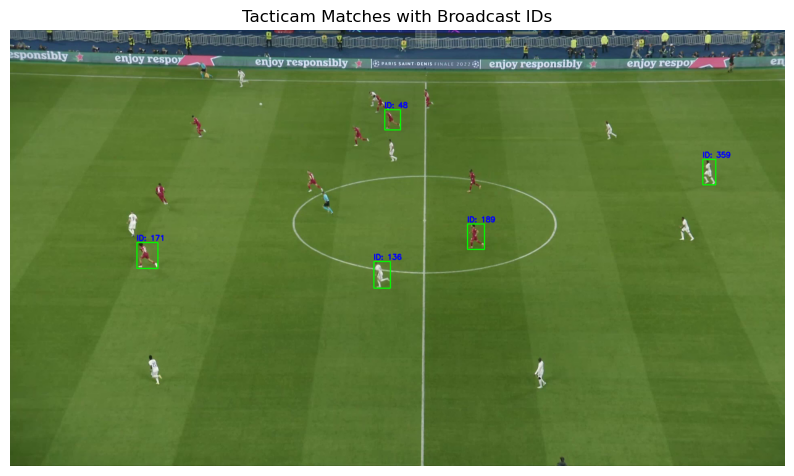

In [25]:
broadcast_path = "broadcast.mp4"
tacticam_path = "tacticam.mp4"

broadcast = detect_players(broadcast_path, max_frames=30)
tacticam = detect_players(tacticam_path, max_frames=30)

if broadcast and tacticam:
    matches = match_players(broadcast, tacticam)
    sample_frame, _ = tacticam[0]
    show_matches(sample_frame.copy(), matches[:5])
else:
    print("⚠️ Matching skipped due to missing video data.")